In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle
warnings.filterwarnings('ignore')
import matplotlib.style as style
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo
from plotly import tools
import seaborn as sns
import missingno as msno
#for visualizing missing data

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Projects/train_hr.csv')
test = pd.read_csv('/content/drive/MyDrive/Projects/test_hr.csv')

In [3]:
train.head()

employee_id         department     region         education gender  \
0        65438  Sales & Marketing   region_7  Master's & above      f   
1        65141         Operations  region_22        Bachelor's      m   
2         7513  Sales & Marketing  region_19        Bachelor's      m   
3         2542  Sales & Marketing  region_23        Bachelor's      m   
4        48945         Technology  region_26        Bachelor's      m   

  recruitment_channel  no_of_trainings  age  previous_year_rating  \
0            sourcing                1   35                   5.0   
1               other                1   30                   5.0   
2            sourcing                1   34                   3.0   
3               other                2   39                   1.0   
4               other                1   45                   3.0   

   length_of_service  KPIs_met >80%  awards_won?  avg_training_score  \
0                  8              1            0                  49   
1                  4              0            0                  60   
2                  7              0            0                  50   
3                 10              0            0                  50   
4                  2              0            0                  73   

   is_promoted  
0            0  
1            0  
2            0  
3            0  
4            0

# Shape of our data

In [4]:
train.shape

(54808, 14)

# Basic Information about our data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


# Descriptive Info of our data

In [6]:
train.describe()

employee_id  no_of_trainings           age  previous_year_rating  \
count  54808.000000     54808.000000  54808.000000          50684.000000   
mean   39195.830627         1.253011     34.803915              3.329256   
std    22586.581449         0.609264      7.660169              1.259993   
min        1.000000         1.000000     20.000000              1.000000   
25%    19669.750000         1.000000     29.000000              3.000000   
50%    39225.500000         1.000000     33.000000              3.000000   
75%    58730.500000         1.000000     39.000000              4.000000   
max    78298.000000        10.000000     60.000000              5.000000   

       length_of_service  KPIs_met >80%   awards_won?  avg_training_score  \
count       54808.000000   54808.000000  54808.000000        54808.000000   
mean            5.865512       0.351974      0.023172           63.386750   
std             4.265094       0.477590      0.150450           13.371559   
min             1.000000       0.000000      0.000000           39.000000   
25%             3.000000       0.000000      0.000000           51.000000   
50%             5.000000       0.000000      0.000000           60.000000   
75%             7.000000       1.000000      0.000000           76.000000   
max            37.000000       1.000000      1.000000           99.000000   

        is_promoted  
count  54808.000000  
mean       0.085170  
std        0.279137  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000



```
# Employees are mostly between 29 and 39 years old (IQR range). The youngest employee is 20, and the oldest is 60.

# Most employees have worked 3 to 7 years. A few employees have over 30 years of service, indicating senior employees.

# Only 35% of employees met more than 80% of their Key Performance Indicators (KPIs), suggesting room for improvement

# 25% of employees scored below 51.
With an Avergae of 63
50% scored below 60.

# Top 25% scored above 76.
A few employees have exceptionally high scores (99).

# Only 8.5% of employees were promoted

# Most employees take only 1 training, but a few take up to 10.
Employees aged 29-39 dominate the workforce.
Performance ratings center around 3, with few at the extremes.
Only 35% meet KPIs, showing performance improvement opportunities.
Very few employees (2.3%) win awards, making it a rare achievement.
Higher training scores may correlate with promotions, but only 8.5% get promoted.
Employees with longer service might have a better chance at promotions, but more data is needed.
```



In [7]:
train.columns

Index(['employee_id', 'department', 'region', 'education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'is_promoted'],
      dtype='object')

# Checking Duplicates

In [8]:
print(f'Duplicates in application data : {train.iloc[:,1:].duplicated().sum()}, ({np.round(100*train.iloc[:,1:].duplicated().sum()/len(train),1)}%)')
print('')

Duplicates in application data : 118, (0.2%)



In [9]:
train.duplicated().sum()

0

In [10]:
duplicate_summary = {}

for col in train.columns:
    duplicates = train[col][train[col].duplicated()]
    if not duplicates.empty:
        duplicate_summary[col] = duplicates.unique()

# Display results
if duplicate_summary:
    print("Columns with duplicates and their values:")
    for col, values in duplicate_summary.items():
        print(f"\nColumn: {col}")
        print(f"Duplicate Values: {values}")
else:
    print("No duplicate values found in any column.")


Columns with duplicates and their values:

Column: department
Duplicate Values: ['Sales & Marketing' 'Operations' 'Analytics' 'Technology' 'Procurement'
 'Finance' 'HR' 'R&D' 'Legal']

Column: region
Duplicate Values: ['region_20' 'region_23' 'region_7' 'region_2' 'region_31' 'region_15'
 'region_22' 'region_26' 'region_5' 'region_4' 'region_1' 'region_28'
 'region_16' 'region_19' 'region_29' 'region_13' 'region_11' 'region_14'
 'region_25' 'region_34' 'region_27' 'region_12' 'region_17' 'region_6'
 'region_30' 'region_32' 'region_8' 'region_24' 'region_10' 'region_21'
 'region_33' 'region_9' 'region_3' 'region_18']

Column: education
Duplicate Values: ["Bachelor's" "Master's & above" nan 'Below Secondary']

Column: gender
Duplicate Values: ['m' 'f']

Column: recruitment_channel
Duplicate Values: ['sourcing' 'other' 'referred']

Column: no_of_trainings
Duplicate Values: [ 1  2  3  4  7  5  6  8  9 10]

Column: age
Duplicate Values: [31 30 35 39 37 34 28 27 33 26 40 24 29 50 41 32 38 25

In [11]:
for i in train.columns:
    print({i:train[i].unique()})

{'employee_id': array([65438, 65141,  7513, ..., 13918, 13614, 51526])}
{'department': array(['Sales & Marketing', 'Operations', 'Technology', 'Analytics',
       'R&D', 'Procurement', 'Finance', 'HR', 'Legal'], dtype=object)}
{'region': array(['region_7', 'region_22', 'region_19', 'region_23', 'region_26',
       'region_2', 'region_20', 'region_34', 'region_1', 'region_4',
       'region_29', 'region_31', 'region_15', 'region_14', 'region_11',
       'region_5', 'region_28', 'region_17', 'region_13', 'region_16',
       'region_25', 'region_10', 'region_27', 'region_30', 'region_12',
       'region_21', 'region_8', 'region_32', 'region_6', 'region_33',
       'region_24', 'region_3', 'region_9', 'region_18'], dtype=object)}
{'education': array(["Master's & above", "Bachelor's", nan, 'Below Secondary'],
      dtype=object)}
{'gender': array(['f', 'm'], dtype=object)}
{'recruitment_channel': array(['sourcing', 'other', 'referred'], dtype=object)}
{'no_of_trainings': array([ 1,  2,  3, 

### education from the above we can see education col has nan values
 previous_year_rating has nan values

In [12]:
train.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [13]:
# Calculate the percentage of missing values for each column
train.isnull().sum() / len(train) * 100

employee_id             0.000000
department              0.000000
region                  0.000000
education               4.395344
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
previous_year_rating    7.524449
length_of_service       0.000000
KPIs_met >80%           0.000000
awards_won?             0.000000
avg_training_score      0.000000
is_promoted             0.000000
dtype: float64

In [14]:
# Treating our missing values

In [15]:
train.education.value_counts()

education
Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: count, dtype: int64

In [16]:
mode = train['education'].mode()
train['education'].fillna(mode[0], inplace=True)

In [17]:
train.previous_year_rating.value_counts()

previous_year_rating
3.0    18618
5.0    11741
4.0     9877
1.0     6223
2.0     4225
Name: count, dtype: int64

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Select features and drop missing values
df_temp = train.dropna(subset=['previous_year_rating'])
X = df_temp[['age', 'length_of_service', 'KPIs_met >80%', 'avg_training_score']]
y = df_temp['previous_year_rating']

# Train a model
clf = RandomForestClassifier()
clf.fit(X, y)

# Predict missing values
missing_idx = train['previous_year_rating'].isna()
train.loc[missing_idx, 'previous_year_rating'] = clf.predict(train.loc[missing_idx, ['age', 'length_of_service', 'KPIs_met >80%', 'avg_training_score']])


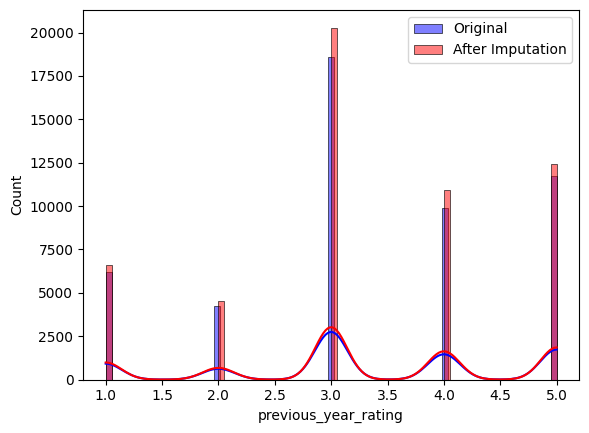

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df_temp['previous_year_rating'], kde=True, label='Original', color='blue')
sns.histplot(train['previous_year_rating'], kde=True, label='After Imputation', color='red', alpha=0.5)
plt.legend()
plt.show()





 EDA (Exploratory Data Analysis)
 Deep Dive into our data



In [20]:
train['is_promoted'].value_counts()

is_promoted
0    50140
1     4668
Name: count, dtype: int64

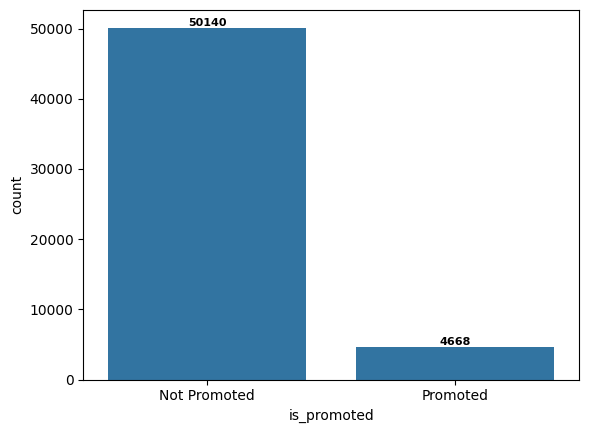

In [21]:
from collections.abc import Container
ax=sns.countplot(x=train['is_promoted'])
plt.gca()
ax.set_xticklabels(['Not Promoted', 'Promoted'])
for container in ax.containers:
  ax.bar_label(container, fmt='%d',label_type='edge',fontsize='8',fontweight='bold')


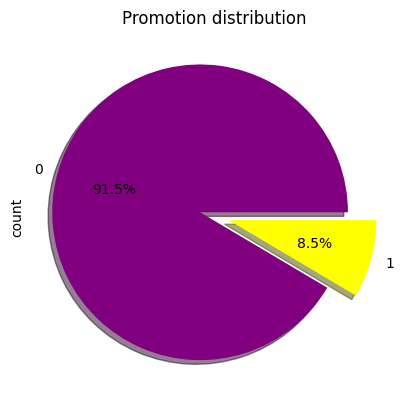

In [22]:
train['is_promoted'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True,
                                         colors=['purple','yellow'],textprops = {'fontsize':10}).set_title('Promotion distribution')

plt.show;

In [23]:
train.education.value_counts()

education
Bachelor's          39078
Master's & above    14925
Below Secondary       805
Name: count, dtype: int64

# understanding promotions wrt to education

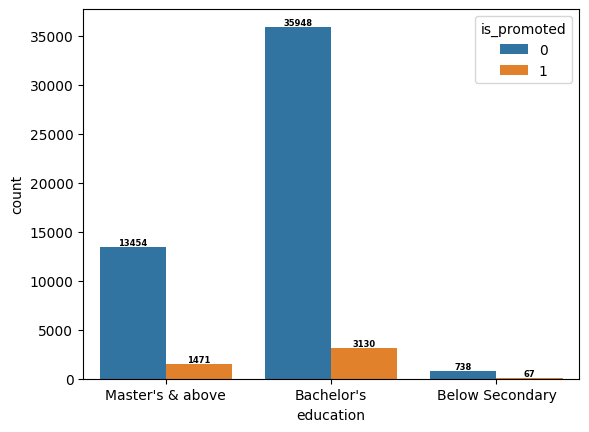

In [24]:
ax = sns.countplot(x=train['education'], hue=train['is_promoted'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=6, fontweight='bold')
plt.show()


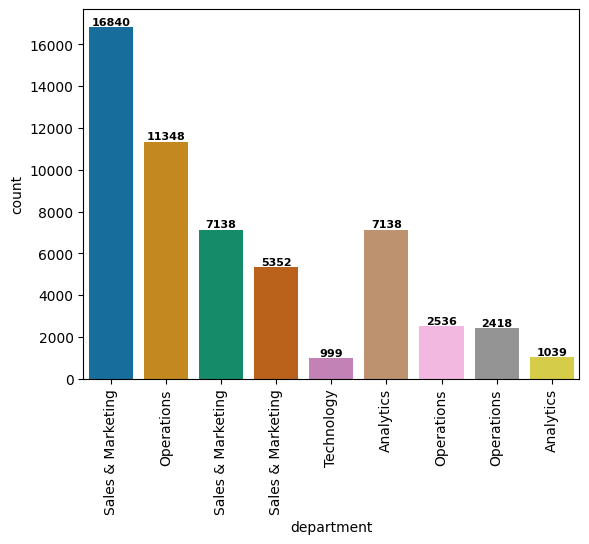

In [25]:
train.department.value_counts()
ax=sns.countplot(x=train['department'], palette='colorblind')
plt.gca()
ax.set_xticklabels(train['department'])
ap=plt.xticks(rotation=90)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=8, fontweight='bold')

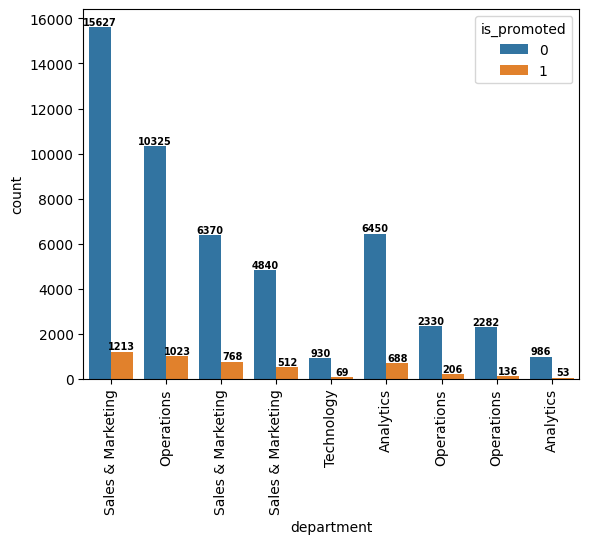

In [26]:
ax=sns.countplot(x=train['department'],hue=train['is_promoted'])
plt.gca()
ax.set_xticklabels(train['department'])
plt.xticks(rotation=90)
for container in ax.containers:
  ax.bar_label(container, fmt="%d",label_type='edge',fontsize=7,fontweight='bold')

In [27]:
train.gender.value_counts()

gender
m    38496
f    16312
Name: count, dtype: int64

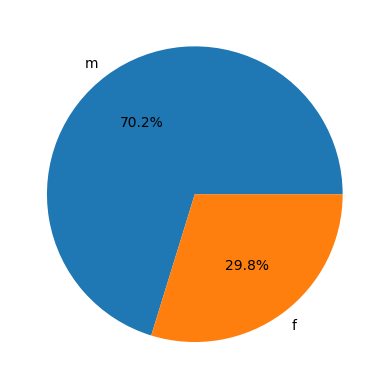

In [28]:
plt.pie(x=train['gender'].value_counts(), labels=train['gender'].value_counts().index, autopct='%1.1f%%')
plt.show()

# Male_count= 70.2% - 38496
# Female_counts= 29.8% - 16312


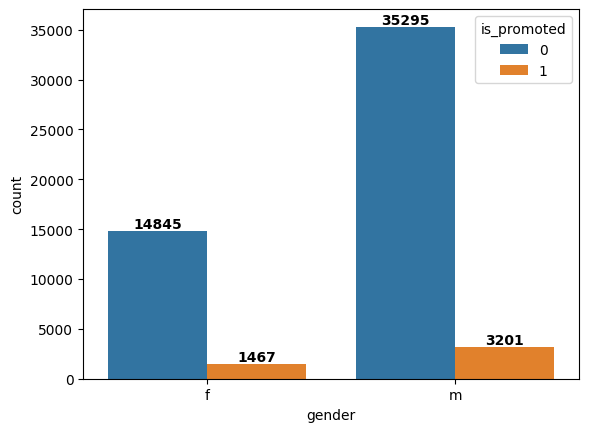

In [29]:
ax=sns.countplot(x=train['gender'],hue=train['is_promoted'])
for container in ax.containers:
  ax.bar_label(container, fmt='%d', label_type='edge',fontweight='bold')

Promotion wrt to gender distribution are as follow :
Female : 14845
Promoted : 1467

Male : 35295
Promoted : 3201

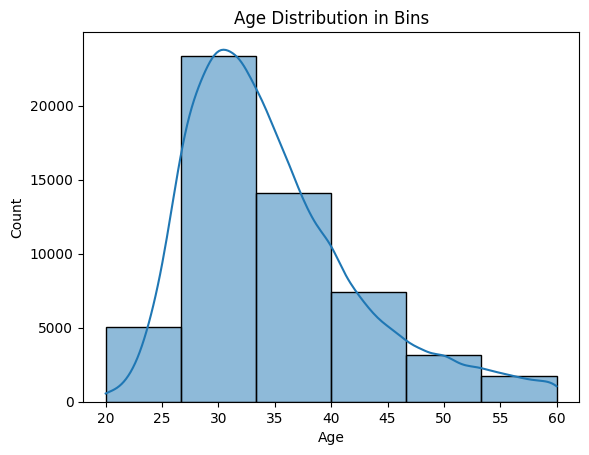

In [30]:
sns.histplot(train['age'], bins=6, kde=True)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution in Bins')
plt.show()

As we had Age min - 20  and max - 60
 we can it is skewed towards righthand side we can say it positive skewness due to higher values towards right side and sharpness of peak

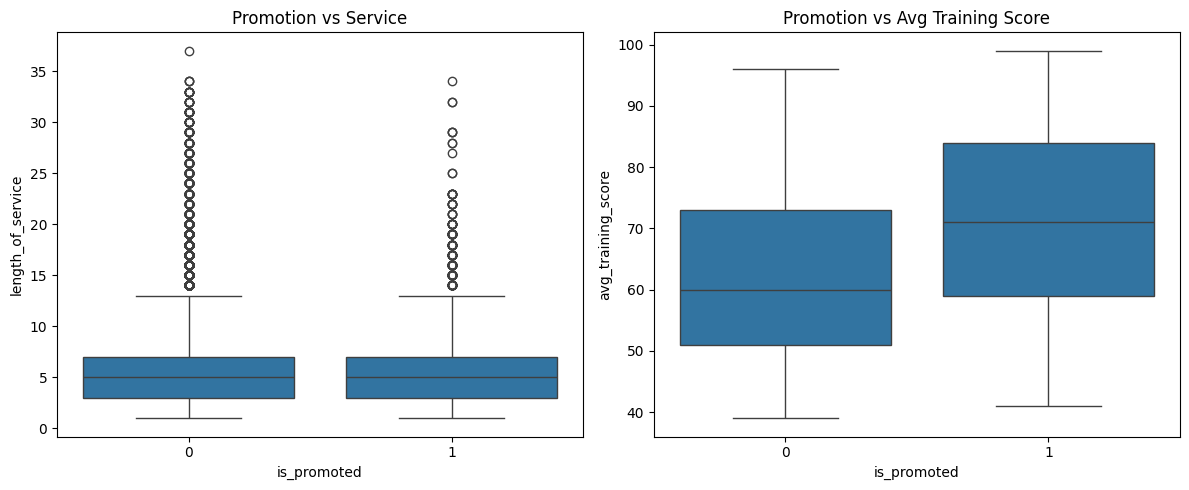

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x=train['is_promoted'], y=train['length_of_service'], ax=axes[0])
axes[0].set_title("Promotion vs Service")

sns.boxplot(x=train['is_promoted'], y=train['avg_training_score'], ax=axes[1])
axes[1].set_title("Promotion vs Avg Training Score")

plt.tight_layout()
plt.show()


In [32]:
colname1=[]
for col in train.columns:
  if (train.dtypes[col]=='int64'):
    colname1.append(col)
    print(col)

employee_id
no_of_trainings
age
length_of_service
KPIs_met >80%
awards_won?
avg_training_score
is_promoted


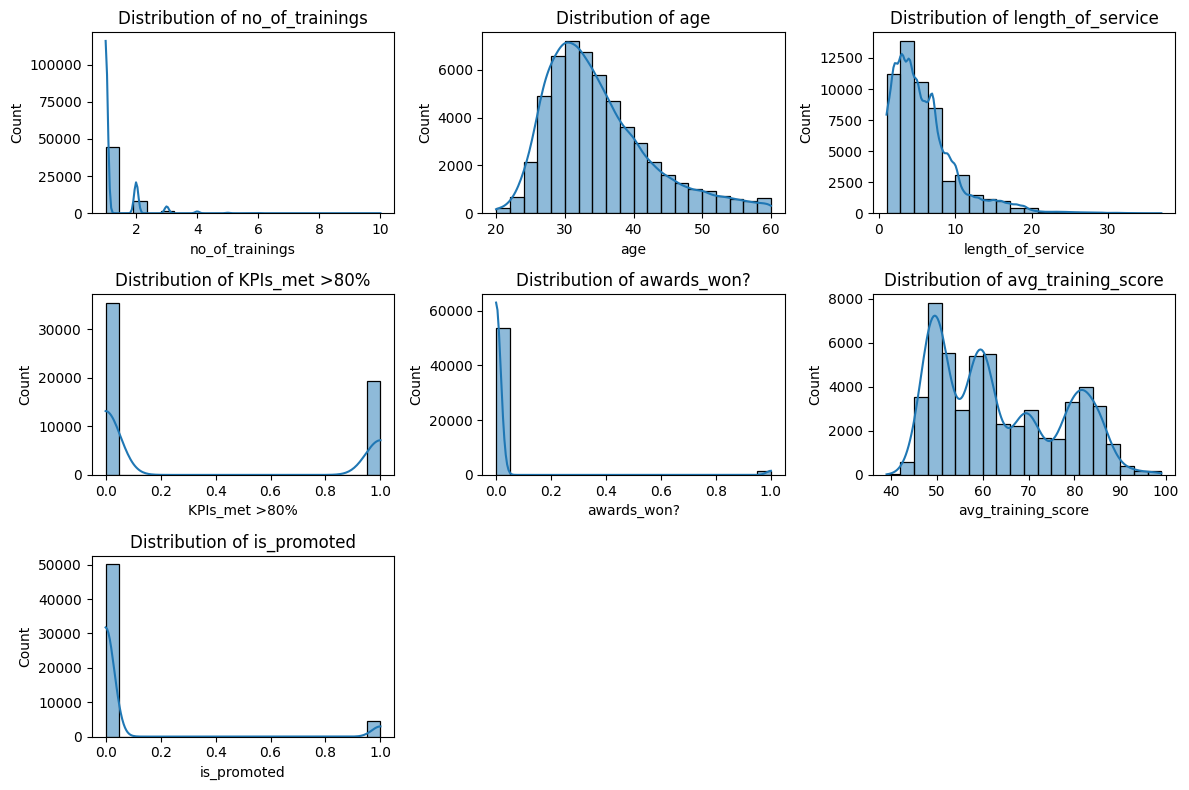

In [33]:
num_cols = ['no_of_trainings', 'age', 'length_of_service', 'KPIs_met >80%',
            'awards_won?', 'avg_training_score', 'is_promoted']

plt.figure(figsize=(12, 8))

# Histogram for distribution
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train[col], bins=20, kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


# Relationship Between Age & Length of Service (Scatter Plot)

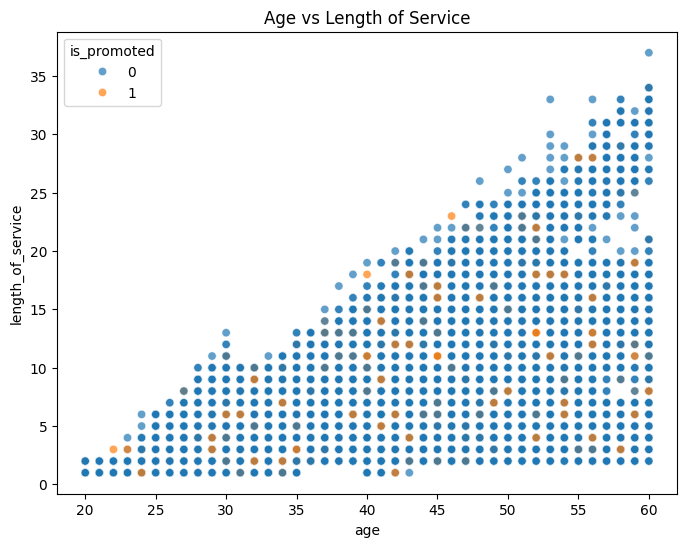

In [34]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train['age'], y=train['length_of_service'], hue=train['is_promoted'], alpha=0.7)
plt.title("Age vs Length of Service")
plt.show()

# Correlation Heatmap (Feature Relationships)
# Helps decide which features are most important for promotion.

In [35]:
plt.figure(figsize=(10, 6))
sns.heatmap(train[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Changing column names

In [36]:
train = train.rename(columns={
    "KPIs_met >80%": "KPIs_met_above_80",
    "awards_won?": "awards_won",
})


In [37]:
numerical_cols = ["employee_id", "no_of_trainings", "age", "length_of_service",
                  "KPIs_met_above_80", "awards_won", "avg_training_score", "is_promoted"]

fig = make_subplots(rows=4, cols=2, start_cell="bottom-left",
                   subplot_titles=("Employee ID", "No. of Trainings", "Age", "Service Length",
                                   "KPIs Met Above 80%", "Awards Won", "Avg Training Score", "Promotion Status"))

fig.add_trace(go.Box(x=train.employee_id, name='Employee ID', boxmean=True), row=1, col=1)
fig.add_trace(go.Box(x=train.no_of_trainings, name='No. of Trainings', boxmean=True), row=1, col=2)
fig.add_trace(go.Box(x=train.age, name='Age', boxmean=True), row=2, col=1)
fig.add_trace(go.Box(x=train.length_of_service, name='Service Length', boxmean=True), row=2, col=2)
fig.add_trace(go.Box(x=train.KPIs_met_above_80, name='KPIs Met Above 80%', boxmean=True), row=3, col=1)
fig.add_trace(go.Box(x=train.awards_won, name='Awards Won', boxmean=True), row=3, col=2)
fig.add_trace(go.Box(x=train.avg_training_score, name='Avg Training Score', boxmean=True), row=4, col=1)
fig.add_trace(go.Box(x=train.is_promoted, name='Promotion Status', boxmean=True), row=4, col=2)

fig.update_layout(height=1000, width=1500, title_text="Distribution of Numerical Features")

fig.show()


# Data Pre-Processing

In [38]:
colname=[]
for col in train.columns:
  if (train.dtypes[col]=='object'):
    colname.append(col)
print(colname)

['department', 'region', 'education', 'gender', 'recruitment_channel']


# Pre-Processing the data

In [39]:
from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
for i in colname:
  train[i]=le.fit_transform(train[i])

Heat Map

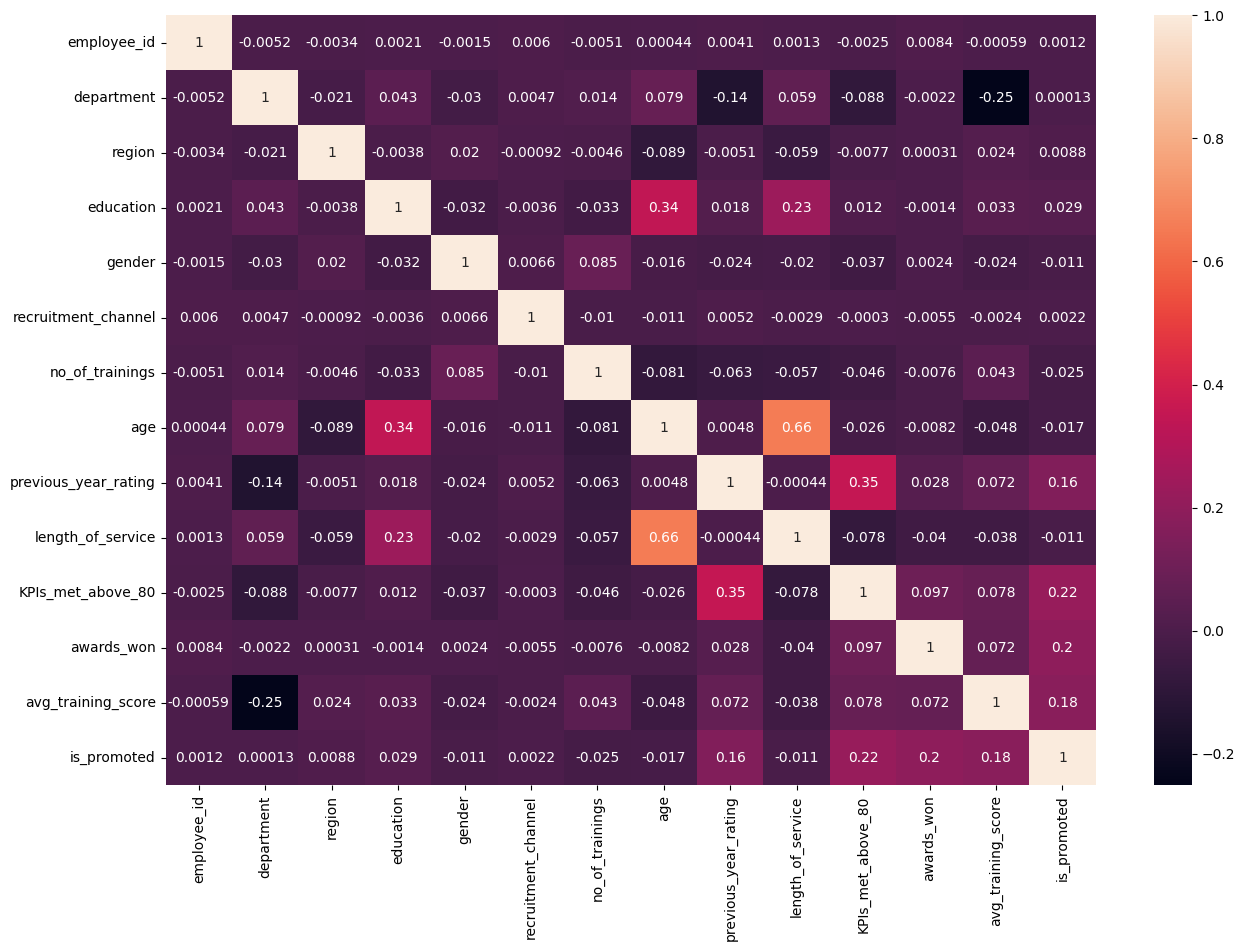

In [40]:
plt.figure(figsize=(15,10))
corr = train.corr()
sns.heatmap(corr,annot = True)
plt.show();

# Feature Selection

In [41]:
train.drop(['employee_id','region'],axis=1,inplace=True)

# Splitting our data

In [42]:
X=train.iloc[:,0:-1]
Y=train.iloc[:,-1]

In [43]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [44]:
print(X.shape)
print(Y.shape)

(54808, 11)
(54808,)


# Scaling
### Scaling data is an essential preprocessing step in machine learning and deep learning
### Scaling ensures that all features have a similar range, preventing models from being biased toward larger values. It improves model performance, convergence speed

In [45]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

scaler.fit(X)
X=scaler.fit_transform(X)

In [46]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

In [47]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(43846, 11)
(43846,)
(10962, 11)
(10962,)


# Model.1
#### Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression()

lr.fit(X_train,Y_train)

LogisticRegression()

In [49]:
y_pred=lr.predict(X_test)

0.9202700237182996
[[10026    28]
 [  846    62]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10054
           1       0.69      0.07      0.12       908

    accuracy                           0.92     10962
   macro avg       0.81      0.53      0.54     10962
weighted avg       0.90      0.92      0.89     10962



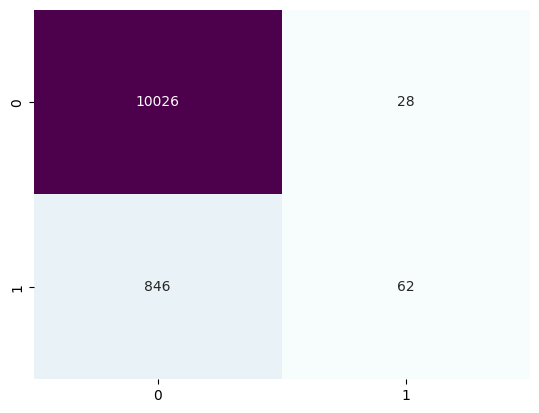

In [50]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
cfm=confusion_matrix(Y_test,y_pred)
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='BuPu')
print(accuracy_score(Y_test,y_pred))
print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test,y_pred))

Model.2 KNN

In [51]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn.fit(X_train,Y_train)

KNeighborsClassifier()

In [52]:
y_predk=knn.predict(X_test)

0.9216383871556285
[[9934  120]
 [ 739  169]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     10054
           1       0.58      0.19      0.28       908

    accuracy                           0.92     10962
   macro avg       0.76      0.59      0.62     10962
weighted avg       0.90      0.92      0.90     10962



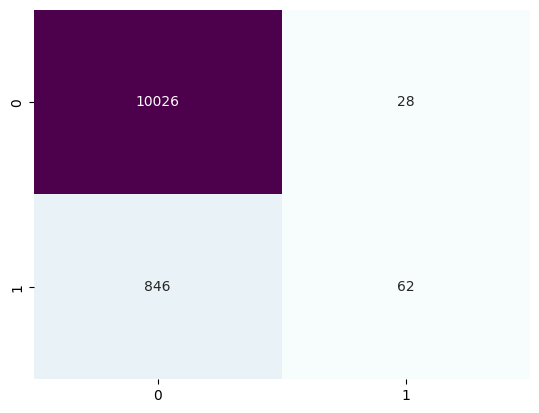

In [53]:
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='BuPu')
print(accuracy_score(Y_test,y_predk))
print(confusion_matrix(Y_test,y_predk))
print(classification_report(Y_test,y_predk))

# Model.3 Decision Tree Classifier

In [54]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dt.fit(X_train,Y_train)

DecisionTreeClassifier()

In [55]:
y_pred_dt=dt.predict(X_test)

0.8984674329501916
[[9447  607]
 [ 506  402]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     10054
           1       0.40      0.44      0.42       908

    accuracy                           0.90     10962
   macro avg       0.67      0.69      0.68     10962
weighted avg       0.90      0.90      0.90     10962



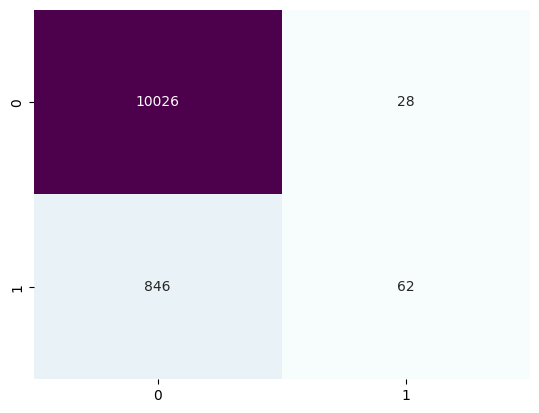

In [56]:
sns.heatmap(cfm, annot=True, fmt='g', cbar=False, cmap='BuPu')
print(accuracy_score(Y_test,y_pred_dt))
print(confusion_matrix(Y_test,y_pred_dt))
print(classification_report(Y_test,y_pred_dt))


Model 4 RandomForest

In [68]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(class_weight='balanced')
rf.fit(X_train,Y_train)

RandomForestClassifier(class_weight='balanced')

In [69]:
y_pred_rf=rf.predict(X_test)

0.9339536580915891
[[9948  106]
 [ 618  290]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     10054
           1       0.73      0.32      0.44       908

    accuracy                           0.93     10962
   macro avg       0.84      0.65      0.70     10962
weighted avg       0.92      0.93      0.92     10962



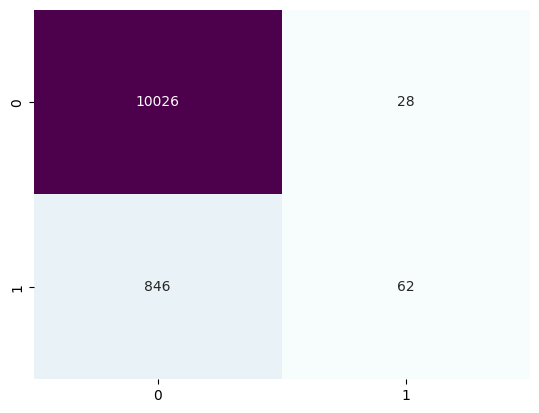

In [70]:
sns.heatmap(cfm , annot=True, fmt="g", cbar=False, cmap='BuPu')
print(accuracy_score(Y_test,y_pred_rf))
print(confusion_matrix(Y_test,y_pred_rf))
print(classification_report(Y_test,y_pred_rf))

In [60]:
print(rf.feature_importances_)

[0.10598992 0.01591263 0.02544126 0.03241656 0.0273036  0.18342108
 0.05907996 0.13190845 0.04587868 0.03088488 0.34176299]


# Model 5 ExtraTreesClassifier

In [61]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_estimators=1000, random_state=10)
et.fit(X_train, Y_train)

ExtraTreesClassifier(n_estimators=1000, random_state=10)

In [62]:
y_pred_et=et.predict(X_test)

0.9277504105090312
[[9877  177]
 [ 615  293]]
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10054
           1       0.62      0.32      0.43       908

    accuracy                           0.93     10962
   macro avg       0.78      0.65      0.69     10962
weighted avg       0.92      0.93      0.92     10962



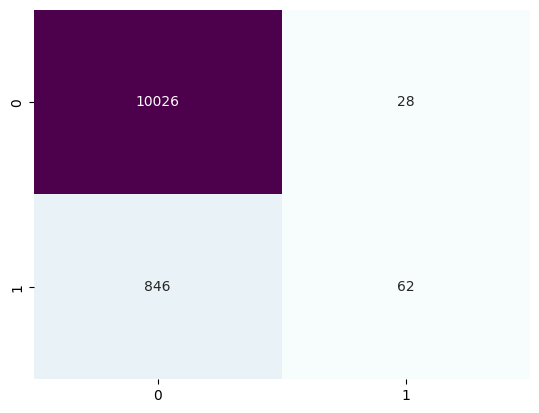

In [63]:
sns.heatmap(cfm , annot=True, fmt="g", cbar=False, cmap='BuPu')
print(accuracy_score(Y_test,y_pred_et))
print(confusion_matrix(Y_test,y_pred_et))
print(classification_report(Y_test,y_pred_et))

In [64]:
models = {
    "SVC": SVC(),
    "Naive Bayes": GaussianNB()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    cm = confusion_matrix(Y_test, y_pred)
    cr = classification_report(Y_test, y_pred)
    results[name] = {
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "classification_report": cr
    }
# Print results
for name, result in results.items():
    print(f"Model: {name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print("Classification Report:")
    print(result['classification_report'])
    print("-" * 50)


Model: SVC
Accuracy: 0.9246
Confusion Matrix:
[[10043    11]
 [  815    93]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     10054
           1       0.89      0.10      0.18       908

    accuracy                           0.92     10962
   macro avg       0.91      0.55      0.57     10962
weighted avg       0.92      0.92      0.90     10962

--------------------------------------------------
Model: Naive Bayes
Accuracy: 0.9152
Confusion Matrix:
[[9915  139]
 [ 791  117]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     10054
           1       0.46      0.13      0.20       908

    accuracy                           0.92     10962
   macro avg       0.69      0.56      0.58     10962
weighted avg       0.89      0.92      0.89     10962

--------------------------------------------------


# Boosting models

Training AdaBoost...
Results for AdaBoost:
Accuracy: 0.9266
Confusion Matrix:
[[10006    48]
 [  757   151]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     10054
           1       0.76      0.17      0.27       908

    accuracy                           0.93     10962
   macro avg       0.84      0.58      0.62     10962
weighted avg       0.92      0.93      0.90     10962

--------------------------------------------------


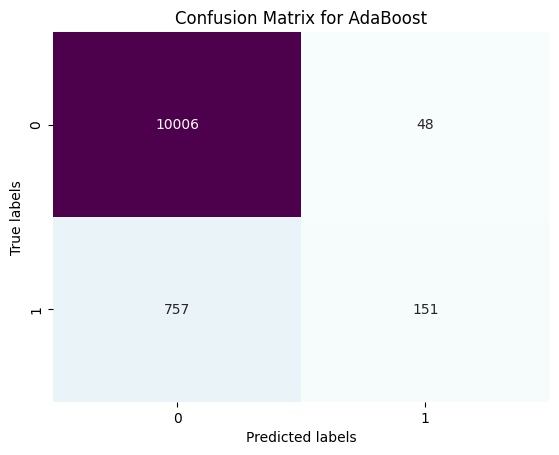

Training GradientBoosting...
Results for GradientBoosting:
Accuracy: 0.9400
Confusion Matrix:
[[10040    14]
 [  644   264]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10054
           1       0.95      0.29      0.45       908

    accuracy                           0.94     10962
   macro avg       0.94      0.64      0.71     10962
weighted avg       0.94      0.94      0.92     10962

--------------------------------------------------


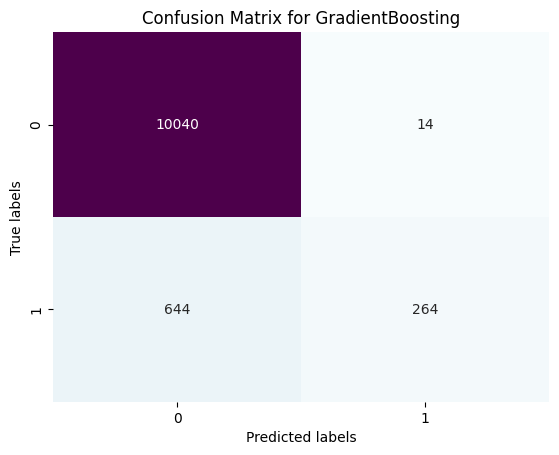

Training XGBoost...
Results for XGBoost:
Accuracy: 0.9422
Confusion Matrix:
[[10011    43]
 [  591   317]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10054
           1       0.88      0.35      0.50       908

    accuracy                           0.94     10962
   macro avg       0.91      0.67      0.73     10962
weighted avg       0.94      0.94      0.93     10962

--------------------------------------------------


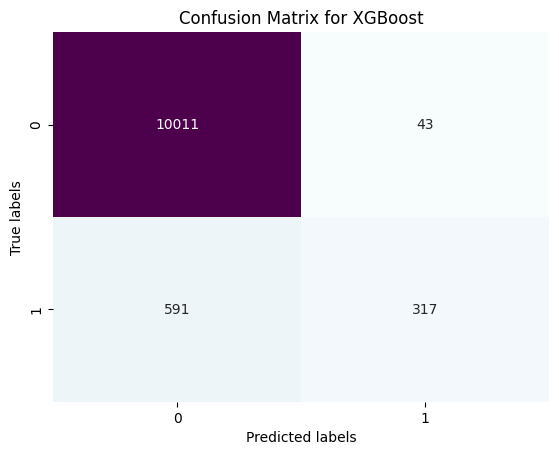

Training CatBoost...
Results for CatBoost:
Accuracy: 0.9426
Confusion Matrix:
[[10025    29]
 [  600   308]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10054
           1       0.91      0.34      0.49       908

    accuracy                           0.94     10962
   macro avg       0.93      0.67      0.73     10962
weighted avg       0.94      0.94      0.93     10962

--------------------------------------------------


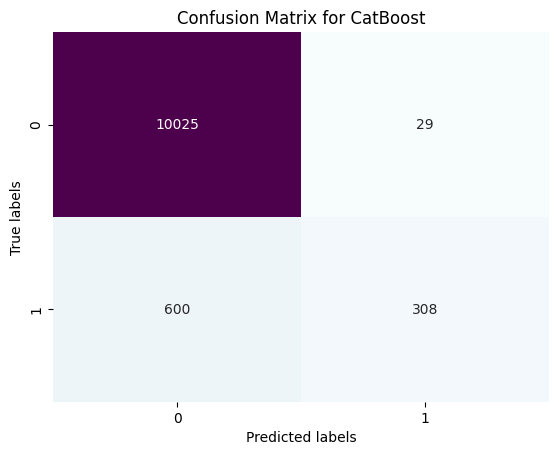

In [65]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# Define the boosting models
boosting_models = {
    "AdaBoost": AdaBoostClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)  # Suppress CatBoost output
}

# Train and evaluate the boosting models
boosting_results = {}
for name, model in boosting_models.items():
    print(f"Training {name}...")
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    cm = confusion_matrix(Y_test, y_pred)
    cr = classification_report(Y_test, y_pred)
    boosting_results[name] = {
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "classification_report": cr,
        "model": model
    }

    # Print the results
    print(f"Results for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(cr)
    print("-" * 50)
    # Plotting the confusion matrix
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap='BuPu')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


# Tuneing our Xgboost model

In [66]:
from sklearn.model_selection import GridSearchCV
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid = {
  'max_depth': [3, 4, 5],
  'learning_rate': [0.01, 0.1, 0.2],
  'n_estimators': [100, 200, 300],
  'colsample_bytree': [0.7, 0.8],
  'subsample': [0.8, 0.9],
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='accuracy', cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, Y_train)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Test Accuracy: {accuracy_score(Y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))
print("Classification Report:")
print(classification_report(Y_test, y_pred))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.9}
Best cross-validation score: 0.94
Test Accuracy: 0.9433
Confusion Matrix:
[[10030    24]
 [  598   310]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10054
           1       0.93      0.34      0.50       908

    accuracy                           0.94     10962
   macro avg       0.94      0.67      0.73     10962
weighted avg       0.94      0.94      0.93     10962



In [77]:
# Calculate class weight
scale_pos_weight = len(Y_train[Y_train == 0]) / len(Y_train[Y_train == 1])

# Train XGBoost with class weight
model = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, Y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [78]:
y_pred_m=model.predict(X_test)

0.7964787447546068
[[8011 2043]
 [ 188  720]]
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     10054
           1       0.26      0.79      0.39       908

    accuracy                           0.80     10962
   macro avg       0.62      0.79      0.64     10962
weighted avg       0.92      0.80      0.84     10962



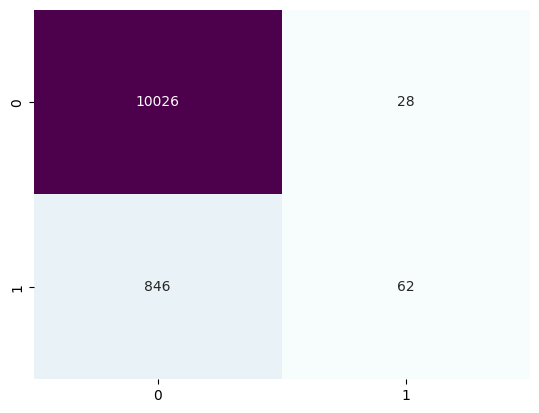

In [79]:
sns.heatmap(cfm , annot=True, fmt="g", cbar=False, cmap='BuPu')
print(accuracy_score(Y_test,y_pred_m))
print(confusion_matrix(Y_test,y_pred_m))
print(classification_report(Y_test,y_pred_m))

In [84]:
print(len(y_probs))  # Should be 10787
print(len(Y_test))   # Should also be 10787


10962
10962


In [85]:
y_probs = model.predict_proba(X_test)[:, 1]  # Ensure X_test is used

In [86]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(Y_test, y_probs)

# Ensure threshold length matches y_probs
thresholds = thresholds[:len(precisions)-1]


In [126]:
valid_indices = (precisions[:-1] >= 0.5) & (recalls[:-1] >= 0.5)

if any(valid_indices):  # If valid values exist
    best_threshold = thresholds[valid_indices][0]
else:  # Default to median threshold
    best_threshold = 0.88 # Change this based on experiment


In [127]:
# Convert probabilities to class labels based on the new threshold
y_pred_new = (y_probs >= best_threshold).astype(int)

# Evaluate the new predictions
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred_new))

print("\nClassification Report:")
print(classification_report(Y_test, y_pred_new))


Confusion Matrix:
[[10018    36]
 [  603   305]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10054
           1       0.89      0.34      0.49       908

    accuracy                           0.94     10962
   macro avg       0.92      0.67      0.73     10962
weighted avg       0.94      0.94      0.93     10962



In [108]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight' : ['balanced', 'balanced_subsample'],

}

# Initialize RandomForestClassifier with balanced class weights
rf = RandomForestClassifier()

# Grid search with cross validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=1, verbose=2, scoring='accuracy')

# Fit grid search to the data
grid_search.fit(X_train, Y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train RF with best parameters
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_train, Y_train)

# Predict on test data
y_pred_rf = rf_best.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred_rf))
print("Classification Report:\n", classification_report(Y_test, y_pred_rf))

#plotting confusion matrix
cfm = confusion_matrix(Y_test, y_pred_rf)
sns.heatmap(cfm , annot=True, fmt="g", cbar=False, cmap='BuPu')
plt.show()
# Calculate class weight
scale_pos_weight = len(Y_train[Y_train == 0]) / len(Y_train[Y_train == 1])

# Train XGBoost with class weight
model = XGBClassifier(scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, Y_train)

y_pred_m=model.predict(X_test)
cfm = confusion_matrix(Y_test, y_pred_m)
sns.heatmap(cfm , annot=True, fmt="g", cbar=False, cmap='BuPu')
plt.show()
print(accuracy_score(Y_test,y_pred_m))
print(confusion_matrix(Y_test,y_pred_m))
print(classification_report(Y_test,y_pred_m))
y_probs = model.predict_proba(X_test)[:, 1]  # Ensure X_test is used

precisions, recalls, thresholds = precision_recall_curve(Y_test, y_probs)

# Ensure threshold length matches y_probs
thresholds = thresholds[:len(precisions)-1]

valid_indices = (precisions[:-1] >= 0.5) & (recalls[:-1] >= 0.5)

if any(valid_indices):  # If valid values exist
    best_threshold = thresholds[valid_indices][0]
else:  # Default to median threshold
    best_threshold = 0.45  # Change this based on experiment

# Convert probabilities to class labels based on the new threshold
y_pred_new = (y_probs >= best_threshold).astype(int)

# Evaluate the new predictions

print("Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred_new))

print("\nClassification Report:")
print(classification_report(Y_test, y_pred_new))


Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END class_weight=balanced, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   7.5s
[CV] END class_weight=balanced, max_depth=None, min_sample

0.7964787447546068
[[8011 2043]
 [ 188  720]]
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     10054
           1       0.26      0.79      0.39       908

    accuracy                           0.80     10962
   macro avg       0.62      0.79      0.64     10962
weighted avg       0.92      0.80      0.84     10962

Confusion Matrix:
[[7766 2288]
 [ 157  751]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86     10054
           1       0.25      0.83      0.38       908

    accuracy                           0.78     10962
   macro avg       0.61      0.80      0.62     10962
weighted avg       0.92      0.78      0.82     10962

